# A Robinson Crusoe economy or how to build your own model

As ``respy`` progressed quite rapidly 

In [1]:
%matplotlib inline

import io
import pandas as pd
import respy as rp
from pathlib import Path
from time import time

In [2]:
%%writefile robinson-crusoe.csv

category,name,value
delta,delta,0.95
wage_fishing,exp_fishing,0.1
nonpec_home,constant,2
shocks,sd_fishing,1
shocks,sd_home,1
shocks,corr_home_fishing,-0.2
meas_error,sd_fishing,0.1

Overwriting robinson-crusoe.csv


In [3]:
%%writefile robinson-crusoe.yaml

estimation_draws: 10000
estimation_seed: 500
estimation_tau: 50
interpolation_points: -1
n_periods: 10
simulation_agents: 1000
simulation_seed: 132
solution_draws: 10000
solution_seed: 456
covariates:
    constant: "1"

Overwriting robinson-crusoe.yaml


In [4]:
params = Path("robinson-crusoe.csv").resolve()
options = Path("robinson-crusoe.yaml").resolve()

In [5]:
state_space = rp.solve(params, options)

In [6]:
simulate = rp.get_simulate_func(params, options)

In [7]:
df = simulate(params)

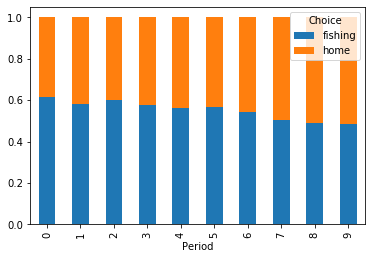

In [8]:
df.groupby("Period").Choice.value_counts(normalize=True).unstack().plot.bar(stacked=True)

In [9]:
criterion = rp.get_crit_func(params, options, df)

In [10]:
start = time()
criterion(params)
end = time()

print(f"One evaluation of the likelihood took {end - start:.2f} seconds.")

One evaluation of the likelihood took 5.66 seconds.


In [11]:
import numpy as np
from estimagic.optimization.optimize import maximize

In [12]:
constr = [{"loc": "shocks", "type": "sdcorr", 'bounds_distance' : 1e-15}, {"loc": "delta", "type": "fixed"}]

In [13]:
params = pd.read_csv(params, index_col=["category", "name"])

params["group"] = params.index.get_level_values('category')
params['lower'] = -np.inf
params['upper'] = np.inf
params

value         group  lower  upper
category     name                                                
delta        delta               0.95         delta   -inf    inf
wage_fishing exp_fishing         0.10  wage_fishing   -inf    inf
nonpec_home  constant            2.00   nonpec_home   -inf    inf
shocks       sd_fishing          1.00        shocks   -inf    inf
             sd_home             1.00        shocks   -inf    inf
             corr_home_fishing  -0.20        shocks   -inf    inf
meas_error   sd_fishing          0.10    meas_error   -inf    inf

In [14]:
results, params = maximize(criterion, params, "nlopt_neldermead", db_options={"rollover": 200}, algo_options={"maxeval": 100}, constraints=constr, dashboard=True)

In [16]:
results

{'fun': -14.082096302100293,
 'internal_x': [0.2330528255684285,
  -6.802599858411258,
  0.7957489233233701,
  -1.3411800047396776,
  2.0570248878948627,
  0.4111665223856548]}